# Задание 5. PageRank 

Марковская цепь строится по графу естественным образом: добавляются переходы во все вершины с вероятностью $\frac{p}{n}$, где $p$ - вероятность перейти на новую страницу, а также для каждой ссылки с текущей страницы добавляется переход с вероятностью $\frac{1-p}{k}$, где $k$ - число исходящих ссылок. Все эти вероятности удобно сохранить в матрицу и последовательно домножать вектор распределения на неё (так как так или иначе переход происходит за квадратичное время, это не ухудшит асимптотического времени работы). Первый алгоритм будет просто последовательно считать вектор распределения на каждом шаге.

In [86]:
import numpy

def transition_matrix(n, links, new_page_prob):
    # determine number of verticies and create adjacency lists
    graph = [list() for _ in range(n)] 
    for u, v in links:
        graph[u].append(v)
        
    # calculate transition matrix
    transition = numpy.array(numpy.zeros((n, n)))
    for i in range(n):
        for j in graph[i]:
            transition[i, j] += (1 - new_page_prob) / len(graph[i])
        if len(graph[i]) == 0:
            for j in range(n):
                transition[i, j] += (1 - new_page_prob) / n
    transition += numpy.ones((n, n)) * new_page_prob / n
    return transition

def page_rank(n, links, epsilon=0.001, new_page_prob=0.15):
    transition = transition_matrix(n, links, new_page_prob)
    # initialize distribution vector and apply transitions
    dist = numpy.matrix([1.0 / n] * n)  
    while True:
        new_dist = dist.dot(transition)
        if abs(new_dist - dist).max() < epsilon:
            return new_dist
        dist = new_dist
    return dist

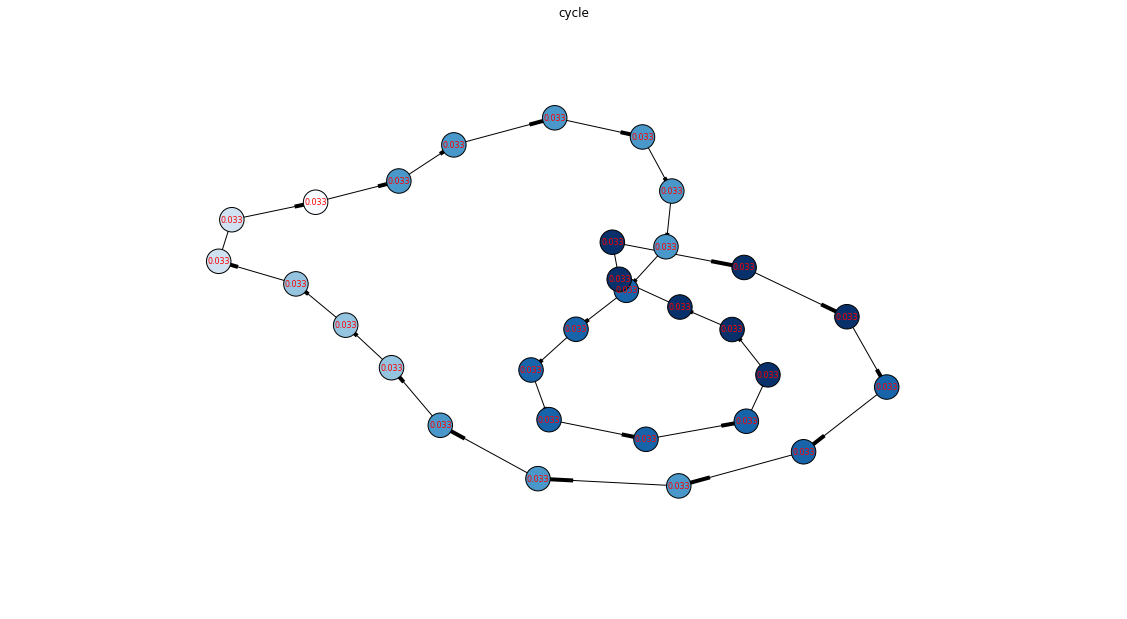

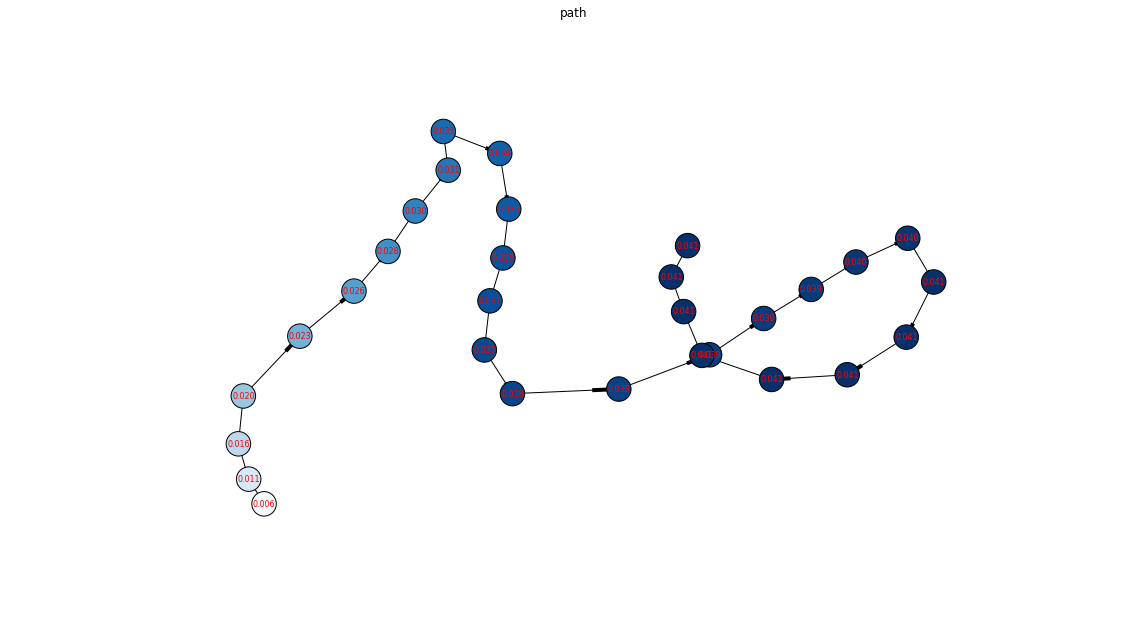

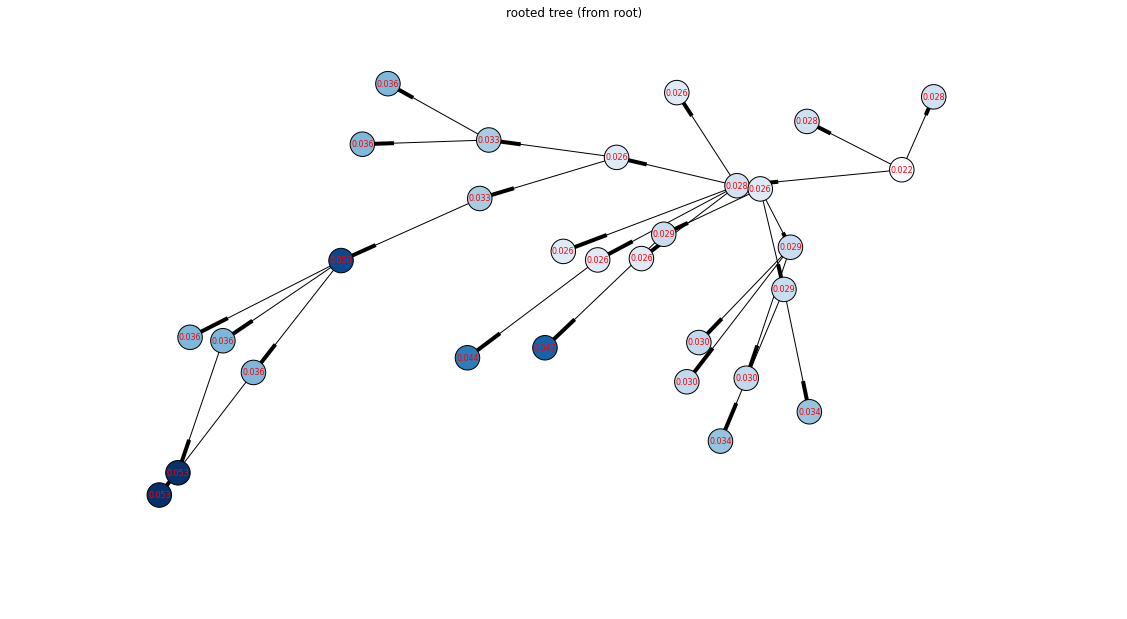

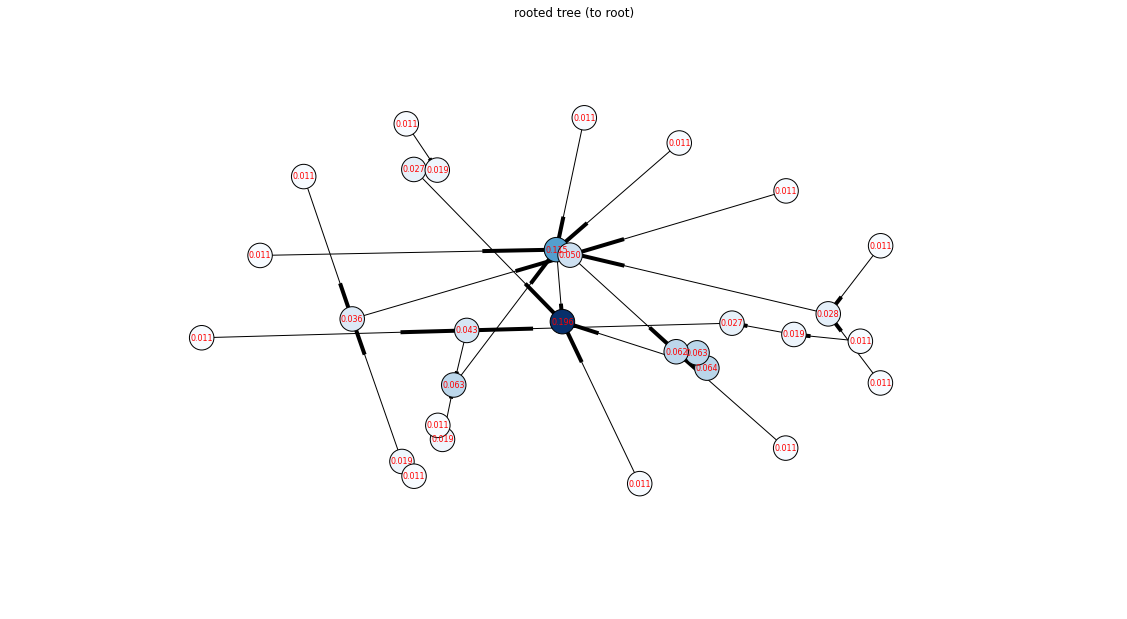

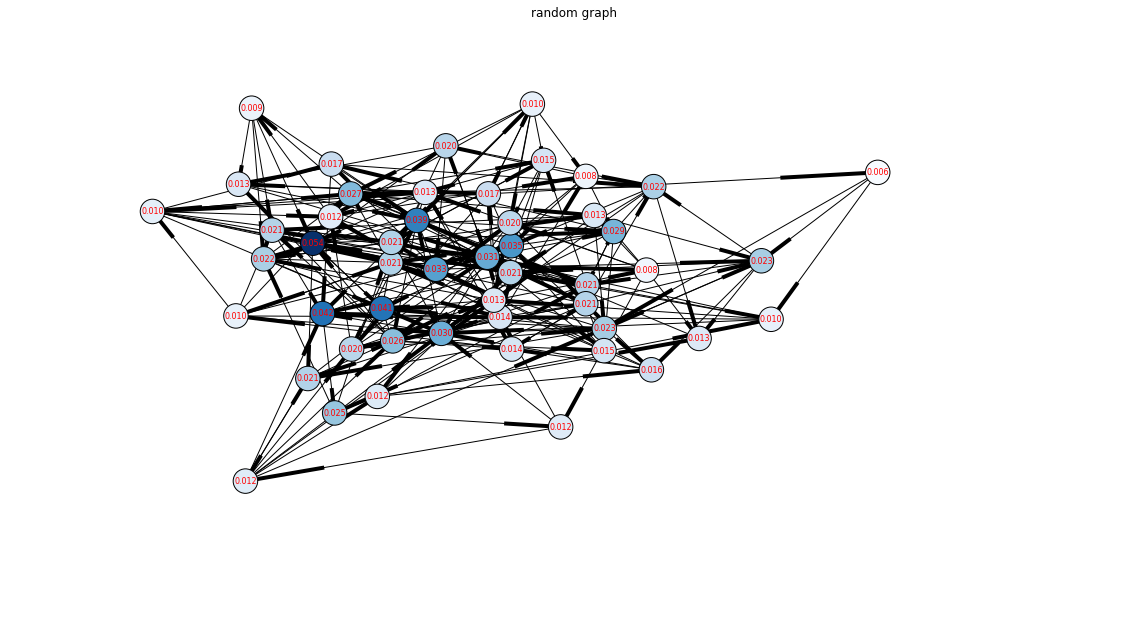

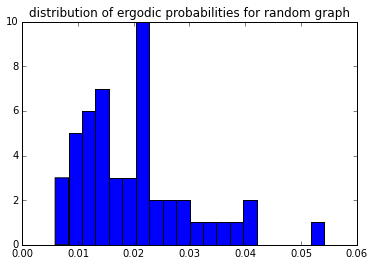

In [97]:
%matplotlib inline
import warnings 
import networkx as nx
from matplotlib import pyplot

# strange warning. https://github.com/pydata/pandas/issues/2841 related?
warnings.simplefilter(action = "ignore", category = FutureWarning)

def draw_graph(n, edges):
    graph = nx.DiGraph()
    graph.add_nodes_from(range(n))
    graph.add_edges_from(edges)
    
    rank = page_rank(n, edges)
    rank = [rank[0, i] for i in range(n)]
    labels = {i : ('%.3f' % rank[i]) for i in range(n)}
    
    pyplot.figure(figsize=(15, 8))
    pos = nx.spring_layout(graph)
    nx.draw(graph, pos, node_size=600,
            node_color=rank, cmap=pyplot.cm.Blues)
    nx.draw_networkx_labels(graph, pos, labels,
                            font_size=8, font_color='r')
    return rank
    
def random_digraph(n, p):
    edge_list = list()
    for i in range(n):
        for j in range(n):
            if numpy.random.random() <= p:
                edge_list.append((i, j))
                
    return n, edge_list

def cycle(n):
    edge_list = list()
    for i in range(n):
        edge_list.append((i, (i + 1) % n))
    return n, edge_list

def path(n):
    edge_list = list()
    for i in range(n - 1):
        edge_list.append((i, (i + 1) % n))
    return n, edge_list

def random_rooted_tree(n):
    edge_list = list()
    for i in range(1, n):
        edge_list.append((numpy.random.randint(0, i), i))
    return n, edge_list

def random_rooted_tree2(n):
    edge_list = list()
    for i in range(1, n):
        edge_list.append((i, numpy.random.randint(0, i)))
    return n, edge_list

rank = draw_graph(*cycle(30))
pyplot.title('cycle')
pyplot.show()
rank = draw_graph(*path(30))
pyplot.title('path')
pyplot.show()
rank = draw_graph(*random_rooted_tree(30))
pyplot.title('rooted tree (from root)')
pyplot.show()
rank = draw_graph(*random_rooted_tree2(30))
pyplot.title('rooted tree (to root)')
pyplot.show()
rank = draw_graph(*random_digraph(50, 0.1))
pyplot.title('random graph')
pyplot.show()
N, bins, patches = pyplot.hist(rank, 20)
pyplot.title('distribution of ergodic probabilities for random graph')
pyplot.show()

Поигравшись с кодом сверху (предлагается запустить несколько раз, меняя параметры, чтобы не загромождать notebook многочисленными похожими графиками), можем сделать следующие наблюдения:
- эргодическое распределение существует всегда (что в общем-то легко доказывается, принимая во внимание переходы между всеми парами вершин с какой-то вероятностью)
- чем выше вероятность ребра, тем меньше уклонение эргодической вероятности от $\frac{1}{n}$.
- распределение эргодических вероятностей в целом выглядит как нормальное, хоть выборка и маловата для таких выводов

Дополнительно интересно попробовать другой метод: матрицу можно последовательно возводить в квадрат, продвигаясь тем самым гораздо быстрее по состояниям марковской цепи.

In [88]:
import timeit

def page_rank_2(n, links, epsilon=0.001, new_page_prob=0.15):
    transition = transition_matrix(n, links, new_page_prob)
    # initialize distribution vector and apply transitions
    dist = numpy.matrix([1.0 / n] * n)
    while True:
        new_dist = dist.dot(transition)
        if abs(new_dist - dist).max() < epsilon:
            return new_dist
        dist = new_dist
        transition = transition.dot(transition)


n, edges = random_digraph(100, 0.05)
print(timeit.timeit('page_rank(n, edges, epsilon=1e-12)',
                    setup=('from __main__ import page_rank, n, edges'),
                    number=100))
print(timeit.timeit('page_rank_2(n, edges, epsilon=1e-12)',
                    setup=('from __main__ import page_rank_2, n, edges'),
                    number=100))

0.14025153299917292
0.41974691600080405


Видно, что первый метод эффективнее, кубическая асимптотику по $n$ проявляется сильнее, чем логарифмический выигрыш в числе итераций (даже при достаточно мелком $\varepsilon$).